#### [ CNN Fashion MNIST MODEL]

[1] 모듈 로딩 및 데이터 준비<hr>

In [1]:
## 모듈 로딩
import torch                                        ## Tensor 및 기본 함수들 관련 모듈
import torch.nn as nn                               ## 인공신경망 관련 모듈
import torch.nn.functional as F # type: ignore
import torch.optim as optim 
from  torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import *

from torchvision.datasets import FashionMNIST       ## 비젼관련 내장 데이터셋 모듈
from torch.utils.data import DataLoader             ## Pytorch의 데이터셋 관련 모듈
from torchinfo import summary                       ## 모델 구조 및 정보 확인 모듈

import torchvision.transforms as transforms         ## 비젼관련 이미지 증강/변환 관련 모듈

import matplotlib.pyplot as plt                     ## 이미지 시각화 


In [2]:
## 이미지 관련 준비
IMG_ROOT = '../data/image/'                         ## 이미지 데이터 저장 폴더 경로



[2] 데이터 로딩 <hr>

In [3]:
## 내장 데이터셋 로딩
trainDS=FashionMNIST(root=IMG_ROOT,
                     download=True,
                     train=True,
                     transform=transforms.ToTensor())

In [4]:
testDS=FashionMNIST(root=IMG_ROOT,
                     download=True,
                     train=False, 
                     transform=transforms.ToTensor())

In [5]:
## 데이터셋 체크
## - 타입
print(f'type         : {type(testDS)}')

## - 속성 : 클래스 정보
print(f'classes      : {testDS.classes}')
print(f'class_to_idx : {testDS.class_to_idx}')

type         : <class 'torchvision.datasets.mnist.FashionMNIST'>
classes      : ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_to_idx : {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [7]:
## - 속성 : 데이터와 타겟
print(f'targets      : {testDS.targets} {len(trainDS.classes)}')
print(f'data         : {testDS.data.shape}')


targets      : tensor([9, 2, 1,  ..., 8, 1, 5]) 10
data         : torch.Size([10000, 28, 28])


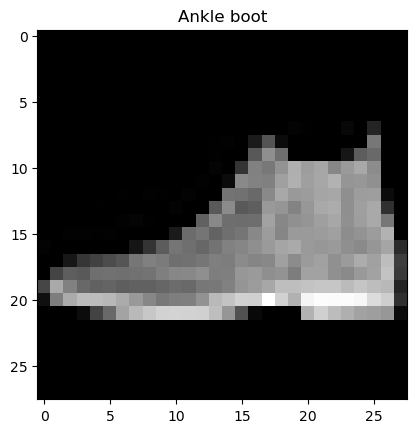

In [8]:
## 이미지 데이터와 타겟 확인
idx_to_classes ={v:k for k, v in testDS.class_to_idx.items()}

plt.imshow(testDS.data[0], cmap='gray')
plt.title(idx_to_classes[testDS.targets[0].item()])
plt.show()

[3] 모델 정의 및 설계 <hr>

In [18]:
# ## DNN MODEL -----------------------------------------------------------------------
# ## 클래스이름 : FashionDNN
# ## 부모클래스 : nn.Module
# ## 모델구현법 : 지도학습 + 다중 분류 
# ## 모델층 구성  입력피쳐/신호     출력/퍼셉트론수    활성화함수
# ## 입  력  층       784             512             ReLu
# ## 은  닉  층       512             256             ReLu
# ## 은  닉  층       256             130             ReLu
# ## 출  력  층       130             10               X
# ## ----------------------------------84----------------------------------------------
class FashionDNN(nn.Module):
     def __init__(self):
         super().__init__()
         self.in_layer   = nn.Flatten()
         self.hd_layer1  = nn.Linear(784, 512)
         self.drop_layer = nn.Dropout(0.25)
         self.hd_layer2  = nn.Linear(512, 256)
         self.hd_layer3  = nn.Linear(256, 130)
         self.out_layer  = nn.Linear(130, 10)
        
     ## 순방향 학습 진행 메서드 
     def forward(self, data):
         ## 3D (BS, H, W) ==> 2D (BS, H*W)
         out = self.in_layer(data)

         out =F.relu(self.hd_layer1(out))
         out = self.drop_layer(out)

         out =F.relu(self.hd_layer2(out))
         out = self.drop_layer(out)

         out =F.relu(self.hd_layer3(out))
         out = self.out_layer(out)
        
         return out

In [19]:
## 모델 구조 확인 
from models import * 

m1 = FashionDNN()
summary(m1, input_size=(100, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionDNN                               [100, 10]                 --
├─Sequential: 1-1                        [100, 10]                 --
│    └─Flatten: 2-1                      [100, 784]                --
│    └─Linear: 2-2                       [100, 128]                100,480
│    └─ReLU: 2-3                         [100, 128]                --
│    └─Linear: 2-4                       [100, 10]                 1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 10.18
Input size (MB): 0.31
Forward/backward pass size (MB): 0.11
Params size (MB): 0.41
Estimated Total Size (MB): 0.83

In [20]:
## DNN모델에 이미지 테스트
testImg = trainDS.data[0:2].float()
pre=m1(testImg)
pre.argmax(axis=1), trainDS.targets[0:2]

(tensor([8, 4]), tensor([9, 0]))

[4] 학습 준비 <hr>

In [21]:
## 학습 설정
EPOCHS      = 10
BATCH_SIZE  = 100
T_ITERATION = int(trainDS.data.shape[0]/BATCH_SIZE)
V_ITERATION = int(testDS.data.shape[0]/BATCH_SIZE)

LR          = 0.001
DEVICE      = 'gpu' if torch.cuda.is_available() else 'cpu'

PAT_CNT     = 10
CLASSES     = len(trainDS.classes)

In [22]:
## 인스턴스 생성
TRAINDL     = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True)
TESTDL      = DataLoader(testDS,  batch_size=BATCH_SIZE, shuffle=True)

MODEL       = FashionDNN()
OPTIMIZER   = optim.Adam(MODEL.parameters(), lr=LR)
SCHEDULER   = ReduceLROnPlateau(OPTIMIZER, mode='min', patience=PAT_CNT)

LOSS_FN     = nn.CrossEntropyLoss()
SCORE_FN    = MulticlassAccuracy(num_classes=CLASSES)

-> 학습 진행 

In [29]:
from torchmetrics.classification import MulticlassAccuracy

def training(model, dataloader, optimizer, loss_fn, score_fn, iteration):
    model.train()

    E_LOSS, E_ACC = 0, 0

    for feature, target in dataloader:
        optimizer.zero_grad()

        pre_y = model(feature)
        loss = loss_fn(pre_y, target.reshape(-1).long())

        acc = score_fn(pre_y, target.reshape(-1))

        loss.backward()
        optimizer.step()

        E_LOSS += loss.item()
        E_ACC += acc.item()

    return E_LOSS / iteration, E_ACC / iteration


In [32]:
## 학습 관련 함수들
## - 검증 함수 : 테스트 또는 검즘용 데이터셋 사용하는 함수
##				W, b 업데이트 안함
##- 검증 함수 --------------------------------------------
##- 검증용 데이터셋으로 모델 검증
##- 학습 지속여부 결정 기준이 됨
##- -----------------------------------------------------
def evaluate(model, dataloader, loss_fn, score_fn, iteration):
    model.eval()
    total_loss, total_score = 0, 0

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            pred = model(x)
            loss = loss_fn(pred, y.reshape(-1).long())
            acc = score_fn(pred, y.reshape(-1))

            total_loss += loss.item()
            total_score += acc.item()

            if i + 1 == iteration:
                break

    return total_loss / iteration, total_score / iteration

In [43]:
MODEL_DIR = '../D0403/'
MODEL_FILE = 'best_model.pt'

In [44]:
## 학습 관련 모듈 로딩
from utils import * 

# 에포크 : DS 처음부터 ~ 끝까지 학습  
HIST ={'Train':[[],[]], 'Valid':[[],[]]}  

BEST_ACC = 0

# 에포크 단위 학습/검증 진행 
for epoch in range(EPOCHS):
    trainLoss, trainAcc = training(MODEL, TRAINDL, OPTIMIZER, LOSS_FN, SCORE_FN, T_ITERATION)
    validLoss, validAcc = evaluate(MODEL, TESTDL, LOSS_FN, SCORE_FN, V_ITERATION)

    # 모델 저장
    if BEST_ACC < validAcc:     # 0 < 0.1212 ==> 0.1212 < 현재 valacc
        torch.save(MODEL, MODEL_DIR+MODEL_FILE)
        BEST_ACC = validAcc

    HIST['Train'][0].append(trainLoss) 
    HIST['Train'][1].append(trainAcc) 
    
    HIST['Valid'][0].append(validLoss) 
    HIST['Valid'][1].append(validAcc) 

    print(f'\nEPOCH[{epoch}/{EPOCHS}]----------------')
    print(f'- TRAIN_LOSS {trainLoss:.5f}  ACC {trainAcc:.5f}')
    print(f'- VALID_LOSS {validLoss:.5f}  ACC {validAcc:.5f}')


EPOCH[0/10]----------------
- TRAIN_LOSS 0.25377  ACC 0.90718
- VALID_LOSS 0.33740  ACC 0.88140

EPOCH[1/10]----------------
- TRAIN_LOSS 0.24549  ACC 0.90899
- VALID_LOSS 0.33317  ACC 0.88604

EPOCH[2/10]----------------
- TRAIN_LOSS 0.23877  ACC 0.91201
- VALID_LOSS 0.34673  ACC 0.87777

EPOCH[3/10]----------------
- TRAIN_LOSS 0.23304  ACC 0.91395
- VALID_LOSS 0.34503  ACC 0.88037

EPOCH[4/10]----------------
- TRAIN_LOSS 0.22519  ACC 0.91664
- VALID_LOSS 0.34287  ACC 0.87942

EPOCH[5/10]----------------
- TRAIN_LOSS 0.22016  ACC 0.91852
- VALID_LOSS 0.32584  ACC 0.88861

EPOCH[6/10]----------------
- TRAIN_LOSS 0.21606  ACC 0.91863
- VALID_LOSS 0.33306  ACC 0.88135

EPOCH[7/10]----------------
- TRAIN_LOSS 0.20982  ACC 0.92272
- VALID_LOSS 0.34296  ACC 0.88001

EPOCH[8/10]----------------
- TRAIN_LOSS 0.20703  ACC 0.92414
- VALID_LOSS 0.33813  ACC 0.88207

EPOCH[9/10]----------------
- TRAIN_LOSS 0.19999  ACC 0.92586
- VALID_LOSS 0.33795  ACC 0.88655


In [48]:
import matplotlib.pyplot as plt

def drawResult(HIST, EPOCHS):
    plt.figure(figsize=(10, 4))

    # Loss 시각화
    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS + 1), HIST['Train'][0], label='Train Loss')
    plt.plot(range(1, EPOCHS + 1), HIST['Valid'][0], label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # Accuracy 시각화
    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS + 1), HIST['Train'][1], label='Train Accuracy')
    plt.plot(range(1, EPOCHS + 1), HIST['Valid'][1], label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


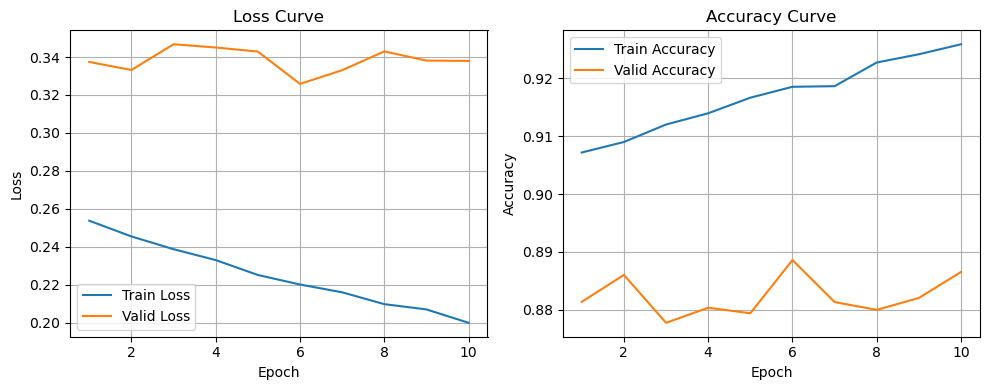

In [46]:
## 학습 시각화
drawResult(HIST, EPOCHS)

[7] 모델 활용 <hr>

In [56]:
## 저장된 모델 로딩
model = FashionDNN()  # 모델 인스턴스 생성
model = torch.load(MODEL_DIR + MODEL_FILE, weights_only=True)
model



UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options 
	(1) Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL models.FashionDNN was not an allowed global by default. Please use `torch.serialization.add_safe_globals([FashionDNN])` to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [55]:
## 예측 - 입력 데이터
## 모델 학습 시 형태의 데이터로 전처리 진행
img, target = testDS[0]

predicted_value = model(img)

In [ ]:
## 저장된 층별 가중치와 바이어스 로딩
WEIGHTS_FILE = 